In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


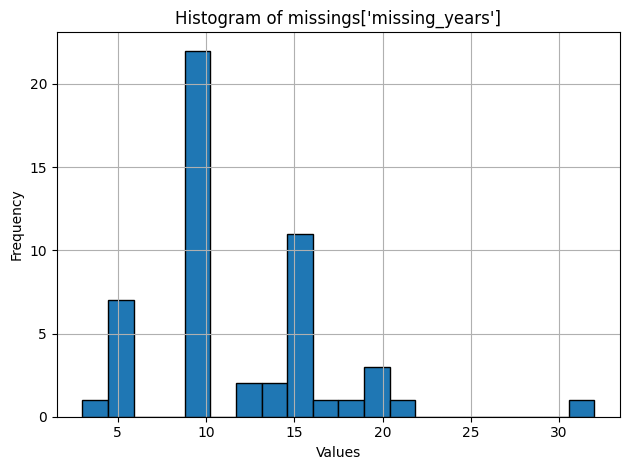

In [2]:
#prep data
df = pd.read_csv("HDR25_panel_format.csv")
hdi = df.pivot_table(
    index="country", columns="year", values="hdi_calc"
)
hdi.columns = [str(col) for col in hdi.columns]

#build hdi histogram to determine rejection threshold
year_cols = [str(y) for y in range(1990, 2024)]
hdi["missing_years"] = hdi[year_cols].isna().sum(axis=1)
missings = hdi[hdi['missing_years'] > 0][["missing_years"]]
plt.hist(missings['missing_years'].dropna(), bins=20, edgecolor='black')
plt.title("Histogram of missings['missing_years']")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
#a big bump at 10, so will keep those and drop more; 35 years - 10 = 25 valids. interpolate out rest
hdi = hdi.dropna(thresh=int(25))
hdi = hdi.interpolate(axis=1).bfill(axis=1).ffill(axis=1)


In [4]:
#standardize for clustering
scaler = StandardScaler()
X = scaler.fit_transform(hdi)



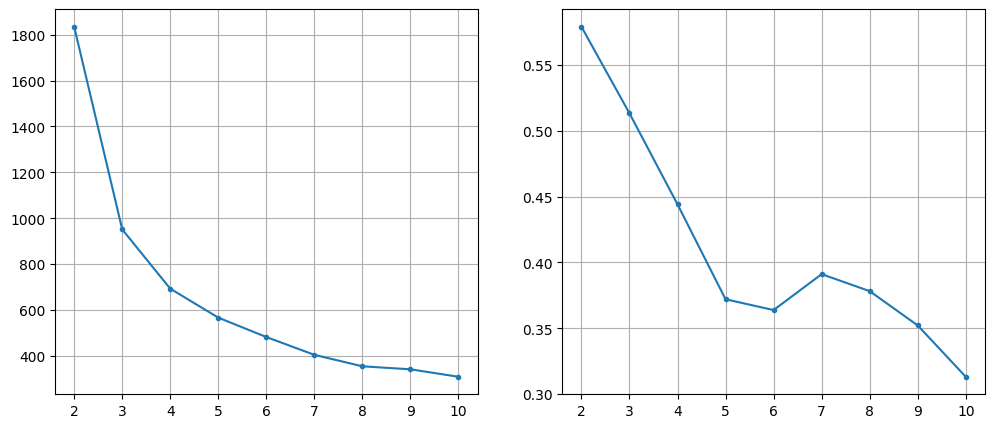

In [5]:
inertias = []
scores = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    scores.append(silhouette_score(X, labels))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#elbow
axes[0].plot(K_range, inertias, marker='.')
axes[0].grid(True)

#silhouette
axes[1].plot(K_range, scores, marker='.')
axes[1].grid(True)

plt.show()

In [7]:
#looks like 5 clusters may be best (@elbow, and silhouette is highest at 2))
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
hdi['cluster'] = kmeans.fit_predict(X)

#cluster centroids
centroids = kmeans.cluster_centers_
deviances = np.linalg.norm(X - centroids[hdi['cluster']], axis=1)

hdi['divergence_score'] = deviances


In [8]:
meta = df[['country','region']].drop_duplicates().set_index('country')
hdi = hdi.join(meta)
laggards = hdi.sort_values('divergence_score', ascending=False).head(10)
print(laggards[['region','cluster','divergence_score']])

                                                                             region  \
country                                                                               
Central African Republic                                         Sub-Saharan Africa   
Niger                                                            Sub-Saharan Africa   
Micronesia (Federated States of)                              East Asia and Pacific   
Chad                                                             Sub-Saharan Africa   
Syrian Arab Republic              Middle East, North Africa, Afghanistan and Pak...   
Angola                                                           Sub-Saharan Africa   
Cabo Verde                                                       Sub-Saharan Africa   
Andorra                                                     Europe and Central Asia   
Madagascar                                                       Sub-Saharan Africa   
Bosnia and Herzegovina                     

In [9]:
change = df.groupby('country')['hdi_calc'].agg(['first','last'])
change['delta'] = change['last'] - change['first']
hdi = hdi.join(change['delta'])
hdi['stagnation_index'] = -hdi['delta'] * hdi['divergence_score']

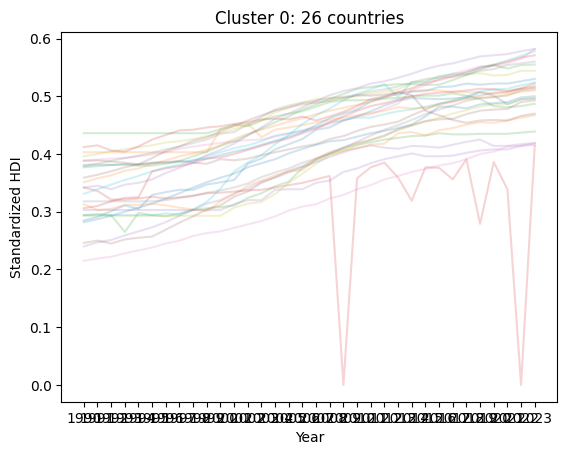

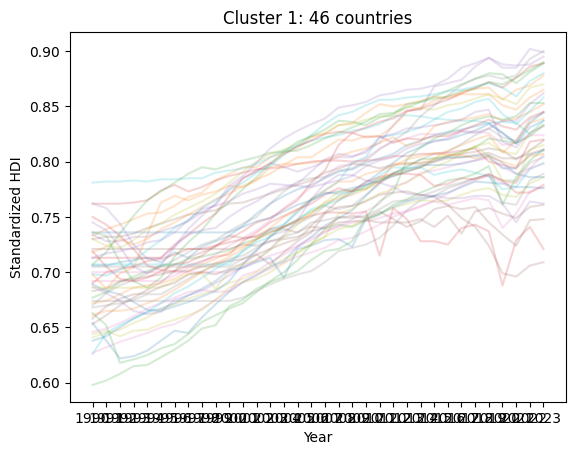

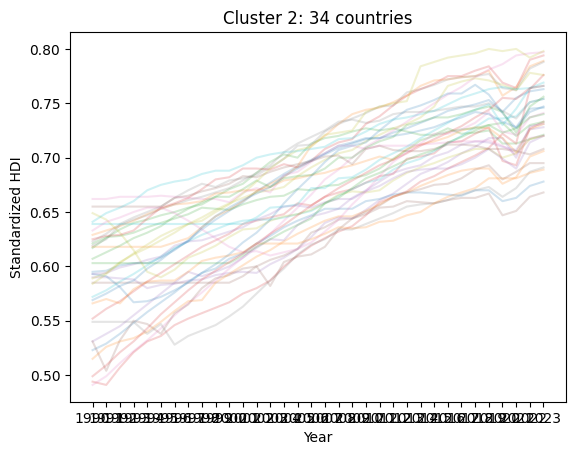

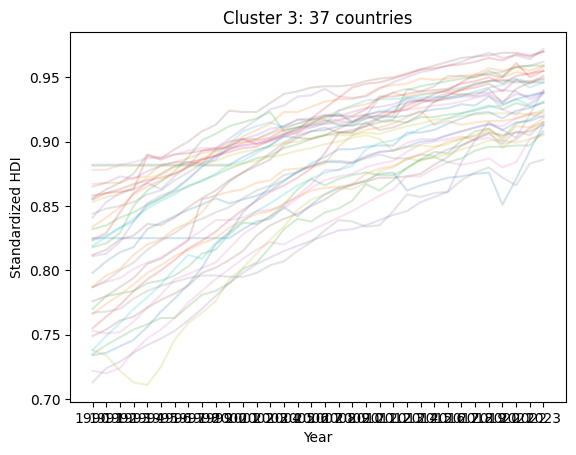

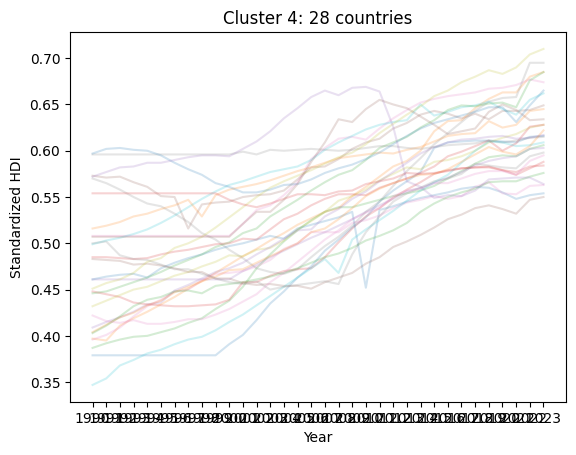

In [ ]:


for i in range(5):
    plt.figure()
    cluster_members = hdi[hdi['cluster']==i].drop(columns=['cluster','divergence_score','region','delta','stagnation_index','missing_years'])
    plt.plot(cluster_members.T, alpha=0.2)
    plt.title(f'Cluster {i}: {len(cluster_members)} countries')
    plt.xlabel('Year')
    plt.ylabel('Standardized HDI')

In [19]:
# cluster_divergence.py
import pandas as pd
import numpy as np
from typing import Optional, Tuple, List, Dict

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import plotly.graph_objects as go
import plotly.express as px

# ---------------------------
# 1) Core builder
# ---------------------------
def build_cluster_divergence(
    panel_csv_path: str = "HDR25_panel_format.csv",
    hdi_col: str = "hdi_calc",
    country_col: str = "country",
    region_col: str = "region",
    year_col: str = "year",
    min_coverage: float = 0.80,       # keep countries with >= 80% of years present
    k: Optional[int] = None,          # if None, auto-select with silhouette
    k_grid: List[int] = (3, 4, 5, 6), # candidates for silhouette selection
    random_state: int = 42
) -> dict:
    """
    Loads panel-format HDR data, builds a trajectory clustering model,
    computes divergence scores and a stagnation index, and returns
    tidy artifacts for downstream visualization.

    Returns a dict with:
      - "wide": standardized wide matrix with cluster, divergence_score, delta, stagnation_index, meta
      - "matrix": original unstandardized wide HDI matrix (countries x years)
      - "centroids": ndarray of cluster centroids in standardized space
      - "model": fitted KMeans model
      - "scaler": fitted StandardScaler
      - "years": ordered list of years used
    """
    df = pd.read_csv(panel_csv_path)

    # Pivot to country x year matrix
    mat = (
        df.pivot_table(index=country_col, columns=year_col, values=hdi_col, aggfunc="first")
          .sort_index(axis=1)  # ensure years are ascending
    )
    years = mat.columns.tolist()

    # Keep countries with sufficient coverage
    mat = mat.dropna(thresh=int(min_coverage * len(years)))

    # Fill remaining gaps (linear along years)
    mat = mat.interpolate(axis=1, limit_direction="both")

    # Track meta (region)
    meta = (
        df[[country_col, region_col]].drop_duplicates(subset=[country_col])
          .set_index(country_col)
          .reindex(mat.index)  # align to kept countries
    )

    # Standardize each country's trajectory across its own time points
    scaler = StandardScaler()
    X = scaler.fit_transform(mat.values)  # rows aligned to mat.index

    # Choose k via silhouette if not provided
    if k is None:
        best_k, best_score = None, -np.inf
        for kk in k_grid:
            km = KMeans(n_clusters=kk, random_state=random_state, n_init="auto")
            labels = km.fit_predict(X)
            # silhouette requires >1 label and <n_samples unique labels
            if len(np.unique(labels)) > 1 and len(np.unique(labels)) < len(labels):
                score = silhouette_score(X, labels, metric="euclidean")
                if score > best_score:
                    best_k, best_score = kk, score
        k = best_k if best_k is not None else 4  # safe fallback

    # Fit final KMeans
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
    labels = kmeans.fit_predict(X)
    centroids = kmeans.cluster_centers_

    # Euclidean distance to assigned centroid (divergence)
    dists = np.linalg.norm(X - centroids[labels], axis=1)

    # Compute country-level delta (first→last)
    # Use the same columns/years as in the matrix
    first_vals = mat[years[0]]
    last_vals  = mat[years[-1]]
    delta = last_vals - first_vals

    # Combine into a tidy frame (one row per country)
    wide = pd.DataFrame({
        "cluster": labels,
        "divergence_score": dists,
        "delta": delta,
    }, index=mat.index)

    # A composite that prioritizes *low progress* and *high divergence*
    # (flip the sign of delta so stagnation grows when delta is small/negative)
    # Add small epsilon to avoid zero-product issues
    eps = 1e-6
    wide["stagnation_index"] = (wide["divergence_score"]) * (1 - (wide["delta"] - wide["delta"].min()) /
                                                             (wide["delta"].max() - wide["delta"].min() + eps))

    # Attach meta and convenience columns
    wide = wide.join(meta)
    wide["country"] = wide.index
    wide["first_year"] = years[0]
    wide["last_year"] = years[-1]

    return {
        "wide": wide,
        "matrix": mat,
        "centroids": centroids,
        "model": kmeans,
        "scaler": scaler,
        "years": years
    }


# ---------------------------
# 2) Laggards table
# ---------------------------
def make_laggards_table(
    model_artifacts: dict,
    sort_by: str = "stagnation_index",   # or "divergence_score"
    top_n: int = 12
) -> pd.DataFrame:
    """
    Returns a ranked table of laggards with useful columns for display.
    """
    wide = model_artifacts["wide"].copy()
    mat = model_artifacts["matrix"]
    years = model_artifacts["years"]

    # Bring first/last hdi into the table for context
    wide["hdi_first"] = mat[years[0]].reindex(wide.index)
    wide["hdi_last"]  = mat[years[-1]].reindex(wide.index)
    wide["hdi_change"] = wide["hdi_last"] - wide["hdi_first"]

    cols = [
        "country", "region", "cluster",
        "hdi_first", "hdi_last", "hdi_change",
        "divergence_score", "stagnation_index"
    ]
    return (wide[cols]
            .sort_values(sort_by, ascending=False)
            .head(top_n)
            .reset_index(drop=True))


# ---------------------------
# 3) Plotly visualizations
# ---------------------------
def fig_clusters_with_outliers(
    model_artifacts: dict,
    laggards: pd.DataFrame,
    highlight_n: int = 12,
    opacity_members: float = 0.15,
    line_width_mean: int = 3
) -> go.Figure:
    """
    Figure 1:
    - For each cluster: show all member trajectories (light)
    - Overplot cluster mean trajectory (thick)
    - Highlight top-N laggards with stronger lines and labels
    """
    wide = model_artifacts["wide"]
    mat = model_artifacts["matrix"]
    years = model_artifacts["years"]

    # Prepare cluster mean series (in original HDI units)
    means_by_cluster = (
        pd.concat([mat, wide["cluster"]], axis=1)
          .groupby("cluster")[mat.columns]
          .mean()
    )

    # Identify highlight countries (rows in laggards)
    hi_countries = set(laggards["country"].head(highlight_n))

    fig = go.Figure()

    # Plot all members lightly, per cluster
    for c in sorted(wide["cluster"].unique()):
        members = wide[wide["cluster"] == c].index
        for country in members:
            fig.add_trace(go.Scatter(
                x=years, y=mat.loc[country, years],
                mode="lines",
                line=dict(width=1),
                opacity=opacity_members,
                name=f"Cluster {c} member",
                legendgroup=f"cluster_{c}",
                hovertemplate=f"<b>{country}</b><br>Cluster: {c}<br>Year: %{{x}}<br>HDI: %{{y:.3f}}<extra></extra>",
                showlegend=False
            ))
        # Add cluster mean
        fig.add_trace(go.Scatter(
            x=years, y=means_by_cluster.loc[c, years],
            mode="lines",
            line=dict(width=line_width_mean),
            name=f"Cluster {c} mean",
            legendgroup=f"cluster_{c}",
            hovertemplate=f"<b>Cluster {c} mean</b><br>Year: %{{x}}<br>HDI: %{{y:.3f}}<extra></extra>"
        ))

    # Highlight laggards (bold)
    for _, row in laggards.iterrows():
        country = row["country"]
        cluster = int(wide.loc[country, "cluster"])
        fig.add_trace(go.Scatter(
            x=years, y=mat.loc[country, years],
            mode="lines+markers",
            line=dict(width=3),
            name=f"⚠ {country} (cluster {cluster})",
            hovertemplate=f"<b>{country}</b><br>Cluster: {cluster}<br>Year: %{{x}}<br>HDI: %{{y:.3f}}<extra></extra>"
        ))

    fig.update_layout(
        title="HDI Trajectories by Cluster (Means + Highlighted Outliers)",
        xaxis_title="Year",
        yaxis_title="HDI (level)",
        legend_title="Series",
        hovermode="x unified",
        template="plotly_white"
    )
    return fig


def fig_outlier_vs_centroid(
    model_artifacts: dict,
    laggards: pd.DataFrame,
    window: Tuple[int, int] = (2010, 2023)
) -> go.Figure:
    """
    Figure 2:
    For each laggard: plot its trajectory vs. its cluster centroid (in original HDI units),
    on the same axes. Handy to see divergence in the recent window.
    """
    wide = model_artifacts["wide"]
    mat = model_artifacts["matrix"]
    years_all = model_artifacts["years"]
    scaler = model_artifacts["scaler"]
    model = model_artifacts["model"]
    centroids = model_artifacts["centroids"]

    # window years present in data
    y0, y1 = window
    years = [y for y in years_all if (y >= y0 and y <= y1)]

    # Prepare centroid in original HDI units for the same years:
    #   1) centroid is in standardized space across all years
    #   2) invert the scaler to original space along all years
    #   3) then take the slice for the chosen window
    # Build a dataframe of reversed-scaled centroids
    inv_centroids = pd.DataFrame(
        scaler.inverse_transform(centroids),
        columns=years_all
    )[years]  # slice window

    fig = go.Figure()

    for _, row in laggards.iterrows():
        country = row["country"]
        c = int(wide.loc[country, "cluster"])
        # Country series (original units)
        ys_country = mat.loc[country, years]
        # Matching centroid series (original units)
        ys_cent = inv_centroids.loc[c, years]

        fig.add_trace(go.Scatter(
            x=years, y=ys_cent,
            mode="lines",
            line=dict(width=3),
            name=f"Cluster {c} centroid",
            legendgroup=f"{country}",
            hovertemplate=f"<b>Cluster {c} centroid</b><br>Year: %{{x}}<br>HDI: %{{y:.3f}}<extra></extra>"
        ))
        fig.add_trace(go.Scatter(
            x=years, y=ys_country,
            mode="lines+markers",
            line=dict(width=3),
            name=f"{country}",
            legendgroup=f"{country}",
            hovertemplate=f"<b>{country}</b><br>Year: %{{x}}<br>HDI: %{{y:.3f}}<extra></extra>"
        ))

    fig.update_layout(
        title=f"Laggards vs. Their Cluster Centroid (HDI, {years[0]}–{years[-1]})",
        xaxis_title="Year",
        yaxis_title="HDI (level)",
        hovermode="x unified",
        template="plotly_white"
    )
    return fig


# ---------------------------
# 4) Quick usage demo
# ---------------------------
if __name__ == "__main__":
    arts = build_cluster_divergence(
        panel_csv_path="HDR25_panel_format.csv",
        hdi_col="hdi_calc",
        country_col="country",
        region_col="region",
        year_col="year",
        min_coverage=0.80,
        k=None,                   # auto-select via silhouette
        k_grid=[3,4,5,6,7],
        random_state=42
    )

    laggards = make_laggards_table(arts, sort_by="stagnation_index", top_n=12)
    print(laggards)

    fig1 = fig_clusters_with_outliers(arts, laggards, highlight_n=12)
    fig2 = fig_outlier_vs_centroid(arts, laggards, window=(2010, 2023))

    # If running interactively (Jupyter), show:
    fig1.show(); fig2.show()


                     country  \
0   Central African Republic   
1       Syrian Arab Republic   
2                    Namibia   
3                      Congo   
4                    Ukraine   
5      Eswatini (Kingdom of)   
6                   Honduras   
7                   Barbados   
8                    Bahamas   
9         Russian Federation   
10                     Libya   
11                    Norway   

                                               region  cluster  hdi_first  \
0                                  Sub-Saharan Africa        2      0.342   
1   Middle East, North Africa, Afghanistan and Pak...        0      0.572   
2                                  Sub-Saharan Africa        0      0.597   
3                                  Sub-Saharan Africa        0      0.573   
4                             Europe and Central Asia        0      0.750   
5                                  Sub-Saharan Africa        2      0.570   
6                         Latin America and 